In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pandas_profiling import ProfileReport
from sklearn.impute import SimpleImputer

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_4000\1403589902.py:6: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport


In [2]:
# Read in the dataset
train = pd.read_csv('train (1).csv', index_col = 'id')
train['temp_diff'] = train['maxtemp'] - train['mintemp']
test = pd.read_csv('test (1).csv', index_col = 'id')

imputer = SimpleImputer()
imputer.fit(train[['winddirection']])
test['winddirection'] = imputer.transform(test[['winddirection']])
test['temp_diff'] = test['maxtemp'] - test['mintemp']

# <span Style='Color:orange'> Exploratory Data Analysis

## <span Style='Color:red'> Univariate Data

In [3]:
# results = ProfileReport(train)
# results.to_file('Rainfall_EDA.html')

## <span Style='Color:red'> Multivariate Data 

In [4]:
%matplotlib inline

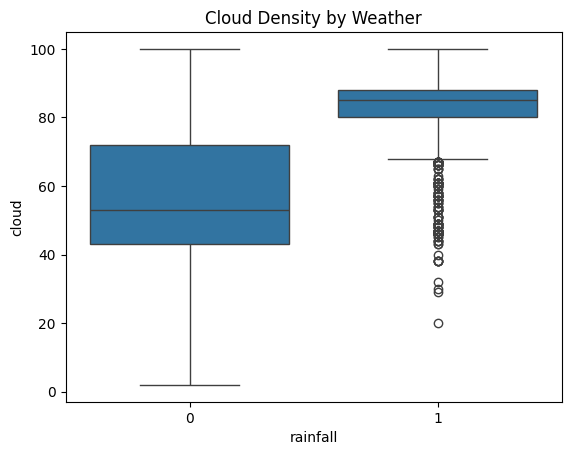

In [5]:
# Box plot between clouds and rainfall
ax = sns.boxplot(data = train, y = 'cloud', x = 'rainfall')
ax.set(title = 'Cloud Density by Weather')
plt.show()

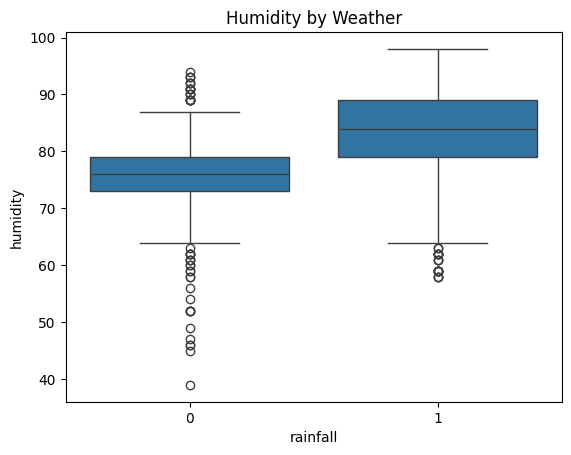

In [6]:
# Box plot between humidity and rainfall
ax = sns.boxplot(data = train, x = 'rainfall', y = 'humidity')
ax.set(title = 'Humidity by Weather')
plt.show()

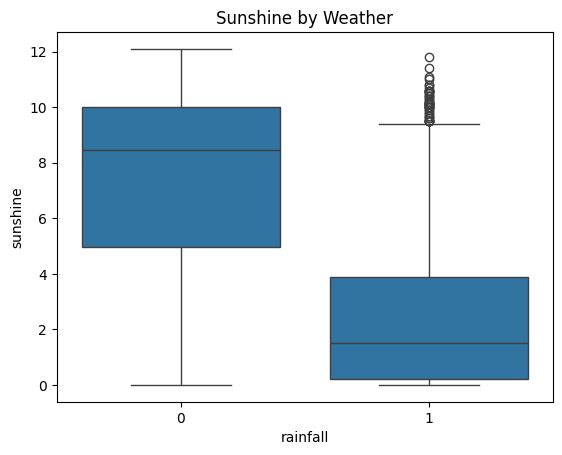

In [7]:
# Sunshine by rainfall
ax = sns.boxplot(data = train, x = 'rainfall', y = 'sunshine')
ax.set(title = 'Sunshine by Weather')
plt.show()

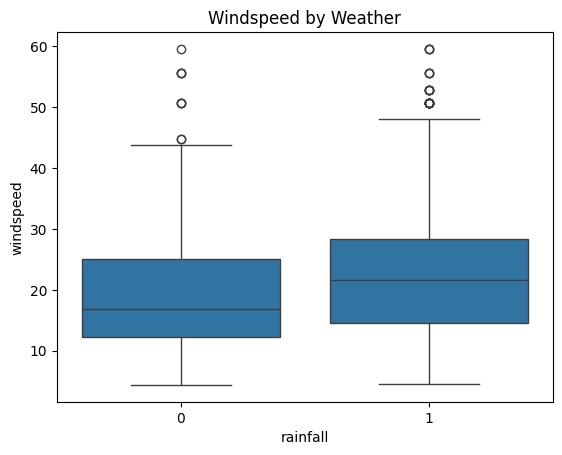

In [8]:
# Rainfall by windspeed
ax = sns.boxplot(data = train, x = 'rainfall', y = 'windspeed')
ax.set(title = 'Windspeed by Weather')
plt.show()

# <span Style = 'Color:orange'> Model Building

In [9]:
# Import libraries
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_score, StratifiedKFold, cross_validate
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from pycaret.classification import ClassificationExperiment
from sklearn.preprocessing import StandardScaler
# Choose the Random State
lucky_number = 777

## <span Style='Color:red'> Separate the training data

In [10]:
X_train = train.copy()
y_train = X_train.pop('rainfall')

## <span Style = 'Color:red'> Build the Straw-Man 

In [11]:
# Define the Validation splits
cv = StratifiedKFold(n_splits = 3, shuffle = True, random_state = lucky_number)

# Fit the Straw man
straw_man = GaussianNB()
cv_results = cross_validate(straw_man, X_train, y_train, 
                            cv = cv, 
                            scoring = 'roc_auc')
cv_results  = pd.DataFrame(cv_results)
display(cv_results)
straw_man_avg = np.round(cv_results['test_score'].mean(), 5)
print(f'Average Straw Man roc_auc: {straw_man_avg}')

,fit_time,score_time,test_score
0,0.002064,0.003242,0.885283
1,0.000996,0.001993,0.861424
2,0.001994,0.001993,0.880808


Average Straw Man roc_auc: 0.87584


## <span Style='Color:red'> Use An Ensemble of models

In [12]:
# Bulid the Ensemble
estimators = [('naive_bayes', GaussianNB()),
              ('svc', SVC(random_state = lucky_number)),
              ('xgb', XGBClassifier(random_state = lucky_number)),
              ('RandomForestClassifier', RandomForestClassifier(random_state = lucky_number))]

meta_model = LogisticRegression(random_state = lucky_number, max_iter = 5000)
ensemble = StackingClassifier(estimators,
                              meta_model,
                              passthrough = True,
                              cv = cv)

# Cross validate
cv_results = pd.DataFrame(cross_validate(ensemble, 
                            X_train,
                            y_train,
                            cv = cv,
                            scoring = 'roc_auc'))
display(cv_results)
stacking_ensemble_avg = np.round(cv_results['test_score'].mean(), 5)
print(f'Stacking Ensemble average roc_auc: {stacking_ensemble_avg}')
print(f'Improvement in Statistics: {np.round(stacking_ensemble_avg - straw_man_avg, 5)}')

,fit_time,score_time,test_score
0,2.205016,0.043820,0.897879
1,2.496400,0.065457,0.872646
2,4.066596,0.137764,0.892626


Stacking Ensemble average roc_auc: 0.88772
Improvement in Statistics: 0.01188


## <span Style='Color:red'> Auto Machine Learning Model

In [13]:
# Set up 
exp = ClassificationExperiment()
exp.setup(train, target = 'rainfall', session_id = lucky_number, fold = 3, train_size = 0.7)

,Description,Value
0,Session id,777
1,Target,rainfall
2,Target type,Binary
3,Original data shape,"(2190, 13)"
4,Transformed data shape,"(2190, 13)"
5,Transformed train set shape,"(1533, 13)"
6,Transformed test set shape,"(657, 13)"
7,Numeric features,12
8,Preprocess,True
9,Imputation type,simple


In [14]:
# Compare the models 
best_models = exp.compare_models(fold = 4,
                                       sort = 'AUC',
                                       n_select = 4,
                                       exclude = ['ridge', 'svm'])
best_models

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.8598,0.8873,0.9385,0.8827,0.9097,0.5968,0.6031,1.0175
lda,Linear Discriminant Analysis,0.8624,0.8870,0.9325,0.8901,0.9107,0.6108,0.6142,0.0425
catboost,CatBoost Classifier,0.8611,0.8774,0.9299,0.8907,0.9097,0.6080,0.6119,1.2400
gbc,Gradient Boosting Classifier,0.8506,0.8725,0.9229,0.8840,0.9029,0.5792,0.5831,0.1750
nb,Naive Bayes,0.8467,0.8723,0.8805,0.9131,0.8963,0.6021,0.6044,2.4800
qda,Quadratic Discriminant Analysis,0.8408,0.8704,0.8952,0.8938,0.8944,0.5707,0.5712,0.0250
et,Extra Trees Classifier,0.8663,0.8698,0.9368,0.8913,0.9134,0.6204,0.6255,0.1000
rf,Random Forest Classifier,0.8624,0.8671,0.9290,0.8928,0.9104,0.6135,0.6172,0.1350
lightgbm,Light Gradient Boosting Machine,0.8539,0.8620,0.9247,0.8865,0.9051,0.5879,0.5914,0.1650
xgboost,Extreme Gradient Boosting,0.8428,0.8534,0.9169,0.8802,0.8979,0.5559,0.5602,0.1050


[LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=1000,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=777, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 LinearDiscriminantAnalysis(covariance_estimator=None, n_components=None,
                            priors=None, shrinkage=None, solver='svd',
                            store_covariance=False, tol=0.0001),
 GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                            learning_rate=0.1, loss='log_loss', max_depth=3,
                            max_features=None, max_leaf_nodes=None,
                            min_impurity_decrease=0.0, min_samples_leaf=1,
                            min_samples_split=2, min_weight_fraction_leaf=0.0,
                            n_estimators=100, n_iter_no_change=None,
          

In [15]:
# Tune the top 4 models
best_models_tuned = [exp.tune_model(model) for model in best_models]
best_models_tuned

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8474,0.8917,0.9195,0.8828,0.9008,0.5708,0.5731
1,0.8532,0.8815,0.9481,0.8690,0.9068,0.5643,0.5763
2,0.8728,0.8747,0.9481,0.8902,0.9182,0.6332,0.6396
Mean,0.8578,0.8826,0.9385,0.8807,0.9086,0.5894,0.5963
Std,0.0109,0.0070,0.0135,0.0088,0.0072,0.0310,0.0306


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8454,0.8913,0.9117,0.8864,0.8988,0.5713,0.5723
1,0.8571,0.8785,0.9455,0.8750,0.9089,0.5808,0.5902
2,0.8787,0.8817,0.9481,0.8968,0.9217,0.6531,0.6581
Mean,0.8604,0.8838,0.9351,0.8861,0.9098,0.6017,0.6069
Std,0.0138,0.0054,0.0166,0.0089,0.0094,0.0365,0.0369


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8513,0.8879,0.9195,0.8872,0.9031,0.5842,0.5859
1,0.8493,0.8731,0.9325,0.8756,0.9031,0.5654,0.5712
2,0.8826,0.8715,0.9429,0.9052,0.9237,0.6699,0.6725
Mean,0.8611,0.8775,0.9316,0.8894,0.9100,0.6065,0.6098
Std,0.0152,0.0074,0.0096,0.0122,0.0097,0.0455,0.0447


Fitting 3 folds for each of 10 candidates, totalling 30 fits


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8532,0.8874,0.9351,0.8780,0.9057,0.5767,0.5826
1,0.8571,0.8774,0.9481,0.8732,0.9091,0.5784,0.5892
2,0.8767,0.8659,0.9377,0.9025,0.9197,0.6543,0.6566
Mean,0.8624,0.8769,0.9403,0.8846,0.9115,0.6031,0.6094
Std,0.0103,0.0088,0.0056,0.0128,0.0060,0.0362,0.0334


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=1000,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=777, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 LinearDiscriminantAnalysis(covariance_estimator=None, n_components=None,
                            priors=None, shrinkage=None, solver='svd',
                            store_covariance=False, tol=0.0001),
 GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                            learning_rate=0.2, loss='log_loss', max_depth=2,
                            max_features='log2', max_leaf_nodes=None,
                            min_impurity_decrease=0.4, min_samples_leaf=3,
                            min_samples_split=2, min_weight_fraction_leaf=0.0,
                            n_estimators=110, n_iter_no_change=None,
        

In [16]:
# Blend the model
auto_ml_ensemble = exp.blend_models(best_models_tuned, method = 'soft')
auto_ml_ensemble

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8571,0.8941,0.9273,0.8881,0.9072,0.5972,0.5999
1,0.8552,0.8807,0.9455,0.8729,0.9077,0.5738,0.5838
2,0.8767,0.8765,0.9403,0.9005,0.9199,0.6524,0.6553
Mean,0.8630,0.8838,0.9377,0.8872,0.9116,0.6078,0.6130
Std,0.0097,0.0075,0.0076,0.0113,0.0059,0.0329,0.0306


VotingClassifier(estimators=[('Logistic Regression',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=1000,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=777,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('Linear Discriminant Analysis',
                              LinearDiscriminantAnalysis(covar...
                                                         max_depth=2,
                                                         max_features='log2',
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.4,
                                                         min_samples_leaf=3,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         n_estimators=110,
                                                         n_iter_no_change=None,
                                                         random_state=777,
                                                         subsample=0.95,
                                                         tol=0.0001,
                                                         validation_fraction=0.1,
                                                         verbose=0,
                                                         warm_start=False))],
                 flatten_transform=True, n_jobs=-1, verbose=False,
                 voting='soft', weights=None)

In [17]:
# Create Predictions
y_pred = exp.predict_model(auto_ml_ensemble)
y_pred

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.8691,0.9004,0.9333,0.8971,0.9149,0.6324,0.6348


,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,temp_diff,rainfall,prediction_label,prediction_score
id,,,,,,,,,,,,,,,
46,47,1018.099976,20.600000,16.100000,14.200000,12.200000,79.0,89.0,1.0,20.0,10.700000,6.4,1,1,0.8544
109,110,1010.099976,30.600000,28.100000,26.799999,25.100000,89.0,89.0,2.0,130.0,21.400000,3.8,1,1,0.9364
835,106,1013.299988,27.799999,25.900000,24.400000,24.700001,92.0,85.0,0.2,190.0,12.600000,3.4,1,1,0.9210
464,100,1017.400024,28.700001,25.799999,24.799999,23.900000,81.0,80.0,1.2,70.0,20.000000,3.9,1,1,0.8864
1759,300,1018.900024,24.500000,23.700001,20.400000,16.000000,93.0,88.0,2.9,50.0,25.000000,4.1,1,1,0.8989
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1370,276,1017.099976,26.600000,24.799999,23.900000,19.299999,75.0,68.0,10.1,70.0,33.400002,2.7,1,0,0.5448
1468,9,1024.699951,10.900000,8.900000,7.000000,4.600000,79.0,96.0,0.0,70.0,27.900000,3.9,1,1,0.8640
1601,142,1008.500000,32.400002,29.900000,27.600000,26.100000,82.0,89.0,1.1,220.0,4.500000,4.8,1,1,0.9065


## <span Style='Color:red'> Neural Network Approach

In [18]:
# Import Libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import keras_tuner as kt

In [19]:
# Scale the features 
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

In [20]:
# # Make a Neural Network
# nn_model = Sequential(
#     [Dense(units = 64, input_shape = (X_train.shape[1],)),
#      Dense(units = 64, activation = 'relu'),
#      Dense(1, activation = 'sigmoid')]
# )
# optimizer = tf.optimizers.Adam(learning_rate = 0.001)
# nn_model.compile(optimizer = optimizer, metrics = [tf.keras.metrics.AUC()], loss = 'binary_crossentropy')
# history = nn_model.fit(X_train_scaled, y_train, epochs = 60, validation_split = 0.2)

In [21]:
# # Define the Model Building Function
# def neural_network_tuner(hp):
#     model = Sequential()
#     model.add(Dense(units = hp.Int('units_1', min_value = 32, max_value = 512, step = 32),
#               activation = 'relu', input_shape = (X_train_scaled.shape[1], )))
#     model.add(Dense(units = hp.Int('units_2', min_value = 32, max_value = 512, step = 32),
#               activation = 'relu'))
#     model.add(Dense(units = 1,
#               activation = 'sigmoid'))
#     optimizer = tf.optimizers.Adam(learning_rate = hp.Float('learning_rate',
#                                                             min_value = 1e-5,
#                                                             max_value = 1e-2,
#                                                             sampling = 'LOG'))
#     model.compile(optimizer = optimizer, 
#                   loss = 'binary_crossentropy',
#                   metrics = [tf.keras.metrics.AUC()])
#     return model

In [22]:
# # Intialize the tuner
# tuner = kt.Hyperband(neural_network_tuner,
#                      objective = 'val_auc',
#                      max_epochs = 60,
#                      factor = 3,
#                      directory = 'C:\Self-made projects\Classification\Rain Prediction',
#                      project_name = 'Tensorflow Neural Network')

In [23]:
# # Search for the best hyperparameters
# tuner.search(X_train_scaled, y_train, epochs = 60, validation_split = 0.2)

In [24]:
# # Retrieve the best model and its hyperparameters
# best_model = tuner.get_best_models(num_models=1)[0]
# best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# print("Best Hyperparameters: ", best_hyperparameters.values)

# <span Style='Color:orange'> Make Predictions

## <span Style='Color:red'> Ensemble approach (currently best Estimator)

In [25]:
# Fit the whole data 
ensemble.fit(X_train, y_train)
predictions = ensemble.predict_proba(test)
submission_df = pd.DataFrame(predictions[:, 1], index = test.index, columns = ['rainfall'])
submission_df.to_csv('submission_dataframe.csv')

## <span Style='Color:red'> Auto-Machine Learning Approach

In [26]:
# Fit the whole data
auto_ml_ensemble.fit(X_train, y_train)
predictions = auto_ml_ensemble.predict_proba(test)
submission_df = pd.DataFrame(predictions[:, 1], index = test.index, columns = ['rainfall'])
submission_df.to_csv('submission_dataframe.csv')

## <span Style = 'Color:red'> Neural Network Approach

In [27]:
# # Scale the test data
# test_scaled = scaler.transform(test)
# predictions = best_model.predict(test_scaled)
# submission_df = pd.DataFrame(predictions, index = test.index, columns = ['rainfall'])
# submission_df.to_csv('submission_dataframe.csv')

In [28]:
# Using the Independent masker (optional)
masker = shap.maskers.Independent(X_train)

# Explaining the model with KernelExplainer
explainer = shap.Explainer(ensemble, masker)
shap_values = explainer.shap_values(X_train[:10])

NameError: name 'shap' is not defined

# <span Style='Color:orange'> Evaluate the Best model

In [ ]:
# Import Libraries
from sklearn.decomposition import  PCA

## <span Style = 'Color:red'> Understanding impacts of each model

In [ ]:
# Fit the PCA
pca = PCA(n_components = 2)
scores = pca.fit_transform(X_train_scaled)

In [ ]:
# Define the components
first_pc = pd.DataFrame(pca.components_[0], index = X_train.columns, columns = ['1st PC'])
second_pc = pd.DataFrame(pca.components_[1], index = X_train.columns, columns = ['2nd PC'])
pc_components = pd.concat([first_pc, second_pc], axis = 1)
pc_components

,1st PC,2nd PC
day,-0.057456,0.020563
pressure,0.351576,0.188062
maxtemp,-0.409715,-0.037131
temparature,-0.406463,-0.087099
mintemp,-0.398855,-0.122409
dewpoint,-0.378309,-0.215422
humidity,0.047669,-0.542267
cloud,0.153724,-0.533553
sunshine,-0.223012,0.477002
winddirection,-0.306361,-0.105769


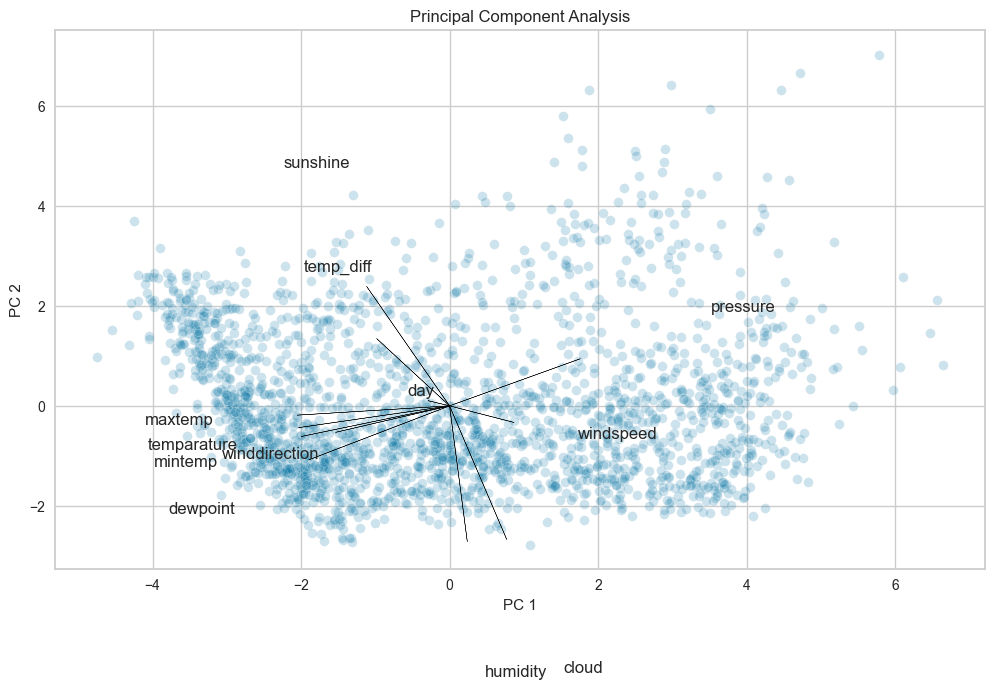

In [ ]:
scale_arrow = s_ = 5
i, j = 0, 1
fig, ax = plt.subplots(figsize = (12, 7))
sns.scatterplot(x = scores[:, 0], y = scores[:,1], ax = ax, alpha = 0.2)
ax.set(xlabel = f'PC {i + 1}', ylabel = f'PC {j + 1}', title = 'Principal Component Analysis')
for k in range(pca.components_.shape[1]):
    ax.arrow(0, 0, s_*pca.components_[i,k], s_*pca.components_[j, k])
    ax.text(pca.components_[i, k]*s_*2,
            pca.components_[j, k]*s_*2,
            X_train.columns[k])

## <span Style='Color:red'> See the decision boundary

Text(0.5, 0.98, 'Comparison Between Actual Values and Fitted Values by the Best model')

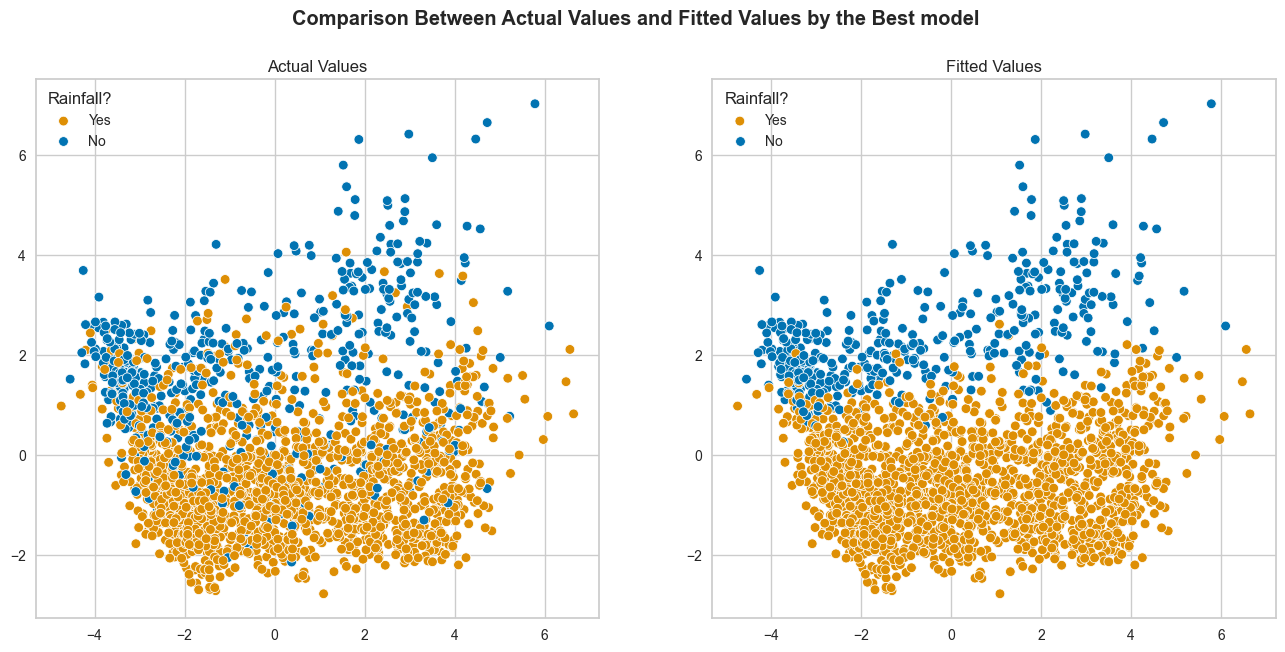

In [ ]:
# Fit the whole data 
ensemble.fit(X_train, y_train)
predictions = ensemble.predict(X_train)

fig, ax = plt.subplots(1, 2, figsize =(16, 7))
sns.scatterplot(x = scores[:, 0], y = scores[:, 1], hue = y_train, 
                ax = ax[0], palette = 'colorblind')
ax[0].legend(title = 'Rainfall?', labels = ['Yes', 'No'])
ax[0].set(title = 'Actual Values')

sns.scatterplot(x = scores[:, 0], y = scores[:, 1], hue = predictions, 
                ax = ax[1], palette = 'colorblind')
ax[1].legend(title = 'Rainfall?', labels = ['Yes', 'No'])
ax[1].set(title = 'Fitted Values')
fig.suptitle('Comparison Between Actual Values and Fitted Values by the Best model', fontweight = 'bold')